![](https://img.shields.io/badge/PO.DAAC-Contribution-%20?color=grey&labelColor=blue)

> From the PO.DAAC Cookbook, to access the GitHub version of the notebook, follow [this link](insert link to notebook).

# Exploring gauges and river discharge in the SWORD of Science (SoS) dataset
## Mapping all discharge algorithms, integrator results, and gauge data
#### *Author: Nikki Tebaldi, NASA JPL PO.DAAC*

## Summary

### Looking at discharge in the SoS

It can be helpful to plot the flow law parameter estimation (FLPE) algorithm discharge alongside the integrator (MOI) discharge produced for that algorithm PLUS overlapping in situ gauge data. Note that not all rivers have gauge data associated with them. In this notebook we will look at the steps to plot SoS discharge values produced from running the Confluence workflow alongside in situ gauge data gathered and stored in the priors.

### Granule structure (background)

The SWORD of Science (SoS) is a community-driven dataset produced for and from the execution of the Confluence workflow in the cloud which enables quick data access and compute on SWOT data. Data granules contain two files, priors and results. The priors file contains prior information, such as in-situ gage data and model output that is used to generate the discharge products. The results file contains the resulting river discharge data products.

The cloud-based workflow ("Confluence") that produces the SoS will produce discharge parameter estimates which the SWOT mission will use to produce discharge. This discharge will be stored in the SWOT shapefiles as the official SWOT discharge. However, the Confluence workflow produces discharge time series alongside the discharge parameter estimates in order to preview what will eventually stored in the SWOT shapefiles. Users can reference the SoS for the latest discharge time series recognizing that the official SWOT discharge data product lives in the SWOT shapefiles.

The SoS is organized by continent following [SWOT River Database (SWORD)](https://www.swordexplorer.com/) structure and naming conventions. It is indexed on the same reach and node identifier dimensions found in SWORD. Time series data is stored by cycle and pass on an observation dimension.

More information is available in the SWOT-Confluence Github repository:
* [Documentation for priors](https://github.com/SWOT-Confluence/documentation/blob/main/documentation/confluence_data_description-priors.pdf)
* [Documentation for results](https://github.com/SWOT-Confluence/documentation/blob/main/documentation/confluence_data_description-results.pdf)

Results are organized into groups corresponding to modules in the SWOT-Confluence processing software. Modules are described in the [Confluence Module Documentation](https://github.com/SWOT-Confluence/documentation/blob/main/documentation/confluence_module_documentation_v1.0.pdf).

You can explore the SoS further in this notebook: Link TBD.

### Locate data for a river that has gauges

We will select the Ohio River as we know it has gauge data associated with it from the USGS but feel free to modify the constants below for your river of choice!

### Table of Gauge Agencies by Continent

The following list the continent with associated gauge agency and group name of the gauge agency as it is stored in the SoS.

| Continent     | Group Name | Gauge Agency                                          |
|---------------|-----------|-------------------------------------------------------|
| Africa        | GRDC       | Global Runoff Data Centre                             |
| Asia          | GRDC       | Global Runoff Data Centre                             |
| Asia          | MLIT       | Ministry of Land, Infrastructure, Transport, Tourism  |
| Europe        | GRDC       | Global Runoff Data Centre                             |
| Europe        | DEFRA      | Department of Environment Food & Rural Affairs        |
| Europe        | EAU        | Hub'Eau France                                        |
| North America | GRDC       | Global Runoff Data Centre                             |
| North America | USGS       | United State Geological Survey                        |
| North America | WSC        | Water Survey Canada                                   |
| Oceania       | GRDC       | Global Runoff Data Centre                             |
| Oceania       | ABOM       | Australian Government Bureau of Meteorology           |
| South America | GRDC       | Global Runoff Data Centre                             |
| South America | DGA        | Direccion General de Aguas                            |
| South America | Hidroweb   | Hidroweb                                              |

## Requirements

### 1. Compute environment 

This tutorial can be run in the following environments:
- **Local compute environment** e.g. laptop, server: this tutorial can be run on your local machine

### 2. Earthdata Login

An Earthdata Login account is required to access data, as well as discover restricted data, from the NASA Earthdata system. Thus, to access NASA data, you need Earthdata Login. Please visit https://urs.earthdata.nasa.gov to register and manage your Earthdata Login account. This account is free to create and only takes a moment to set up.

## Learning Objectives
- To locate in situ gauge data stored in the SoS.
- To locate overlap between in situ observations and times where discharge values were produced.
- Plot gauge data alongside river discharge.


------

## Import Packages

In [1]:
import datetime
import pathlib

import earthaccess
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import pandas as pd

## Authenticate
Authenticate your Earthdata Login (EDL) information using the `earthaccess` python package as follows:

In [2]:
earthaccess.login() # Login with your EDL credentials if asked


## Search and Access SoS data
Locate the SoS data of interest and then download for access.

In [3]:
# Search and locate granules
granule_info = earthaccess.search_data(
    short_name="SWOT_L4_DAWG_SOS_DISCHARGE",
    temporal=("2023-04-07", "2023-04-26"),
)
granule_info

Granules found: 3


[Collection: {'Version': '1', 'ShortName': 'SWOT_L4_DAWG_SOS_DISCHARGE'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -21.794, 'SouthBoundingCoordinate': 25.382, 'EastBoundingCoordinate': 25.382, 'NorthBoundingCoordinate': 81.115}]}}}
 Temporal coverage: {'RangeDateTime': {'EndingDateTime': '2023-04-25T20:01:59.000Z', 'BeginningDateTime': '2023-04-07T22:49:35.000Z'}}
 Size(MB): 983.0999364852905
 Data: ['https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/SWOT_L4_DAWG_SOS_DISCHARGE/eu_sword_v15_SOS_unconstrained_0001_20240228T205029_results.nc', 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/SWOT_L4_DAWG_SOS_DISCHARGE/eu_sword_v15_SOS_unconstrained_0001_20240228T205029_priors.nc'],
 Collection: {'Version': '1', 'ShortName': 'SWOT_L4_DAWG_SOS_DISCHARGE'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -81.139, 'South

In [4]:
# Enter a directory path to store downloaded data in
downloads_dir = pathlib.Path("data_downloads")
downloads_dir.mkdir(parents=True, exist_ok=True)

# Select a priors and results pair to explore
download_links = [[link for link in earthaccess.results.DataGranule.data_links(granule)] for granule in granule_info]
print("Select a priors and results file to explore:")
for downloads in download_links: 
    for download in downloads:
        if "priors" in download: print(download)

Select a priors and results file to explore:
https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/SWOT_L4_DAWG_SOS_DISCHARGE/eu_sword_v15_SOS_unconstrained_0001_20240228T205029_priors.nc
https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/SWOT_L4_DAWG_SOS_DISCHARGE/sa_sword_v15_SOS_unconstrained_0001_20240228T205034_priors.nc
https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/SWOT_L4_DAWG_SOS_DISCHARGE/na_sword_v15_SOS_unconstrained_0001_20240228T205032_priors.nc


In [5]:
# Select Europe ("eu") priors file to work with
priors_link = "https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/SWOT_L4_DAWG_SOS_DISCHARGE/eu_sword_v15_SOS_unconstrained_0001_20240228T205029_priors.nc"

# Select results
results_link = priors_link.replace("priors", "results")

earthaccess.download(priors_link, downloads_dir)
earthaccess.download(results_link, downloads_dir)

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

File eu_sword_v15_SOS_unconstrained_0001_20240228T205029_priors.nc already downloaded


PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

File eu_sword_v15_SOS_unconstrained_0001_20240228T205029_results.nc already downloaded


PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['data_downloads/eu_sword_v15_SOS_unconstrained_0001_20240228T205029_results.nc']

In [6]:
# Open downloaded files to access SoS granule data
priors_download = priors_link.split('/')[-1]
results_download = results_link.split('/')[-1]

priors = nc.Dataset(downloads_dir.joinpath(priors_download), format="NETCDF4")
results = nc.Dataset(downloads_dir.joinpath(results_download), format="NETCDF4")

## Locate gauge and rive discharge data.
We can now locate gauge and river discharge data from the SoS using either the data read directly from S3 or downloaded to your local computer.

In [7]:
# Constants

# Select a river
RIVER_NAME = "Rhine"

# Select a gauge agency
GAUGE_AGENCY = "EAU"

## Locate overlapping identifiers 
Locate overlapping identifiers for reach and gauge data.

In [8]:
# Locate overlapping reach identifier
river_names = results['reaches']['river_name'][:]
river_indexes = np.where(river_names  == RIVER_NAME)

river_reach = results["reaches"]["reach_id"][river_indexes]
print(f"Number of {RIVER_NAME} reach identifiers: {len(river_reach)}")

gauge_reach = priors[GAUGE_AGENCY][f"{GAUGE_AGENCY}_reach_id"][:]
print(f"Number of Gauge reach identifiers: {len(gauge_reach)}")

reach_overlap = np.intersect1d(gauge_reach, river_reach)
print("Overlapping reaches:")
print(reach_overlap)

# Select the first reach
reach_id = reach_overlap[0]
print(f"Reach id selected: {reach_id}")

Number of Rhine reach identifiers: 146
Number of Gauge reach identifiers: 243
Overlapping reaches:
[23267000071 23267000081 23267000121 23267000501]
Reach id selected: 23267000071


## Locate gauge discharge and in situ observation time
Locate discharge and save the in situ observation time for the reach of interest.

In [9]:
# Get reach index for gauge data
reach_gauge_index = np.where(gauge_reach == reach_id)

# Get discharge and filter out missing values
missing = priors[GAUGE_AGENCY][f"{GAUGE_AGENCY}_q"]._FillValue
gauge_discharge = priors[GAUGE_AGENCY][f"{GAUGE_AGENCY}_q"][reach_gauge_index].filled()[0]
nonmissing_indexes_g = np.where(gauge_discharge != missing)
gauge_discharge = gauge_discharge[nonmissing_indexes_g]
print(f"Number of gauge discharge values: {len(gauge_discharge)}.")

# Get time and filter out missing values
gauge_time = priors[GAUGE_AGENCY][f"{GAUGE_AGENCY}_qt"][reach_gauge_index].filled().astype(int)[0]
gauge_time = gauge_time[nonmissing_indexes_g]
print(f"Number of gauge time values: {len(gauge_time)}.")

# Convert time from ordinal value
gauge_time = [ datetime.datetime.fromordinal(gt).strftime("%Y%m%d") for gt in gauge_time ]

Number of gauge discharge values: 3722.
Number of gauge time values: 3722.


## Locate SWOT time
Locate the observations times for SWOT used in the discharge parameter estimation processing.

In [10]:
# Locate the reach identifier
reach_q_index = np.where(results['reaches']['reach_id'][:] == reach_id)
print("Reach Index: ", reach_q_index)

# Retrieve SWOT observation times and filter out missing values
time = results['reaches']['time'][reach_q_index][0]

# Locate indexes where data exists
missing = results['reaches']['time'].missing_value
nonmissing_indexes = np.where(time != missing)
time = time[nonmissing_indexes]

# Convert to discharge time to same format as gauge agency time
swot_ts = datetime.datetime(2000,1,1,0,0,0)   # SWOT timestamp delta
discharge_time = [ (swot_ts + datetime.timedelta(seconds=st)).strftime("%Y%m%d") for st in time ]
print(f"Number of SWOT time values: {len(time)}.")
print(discharge_time)

Reach Index:  (array([13158]),)
Number of SWOT time values: 13.
['20230407', '20230408', '20230409', '20230410', '20230416', '20230417', '20230418', '20230419', '20230420', '20230422', '20230423', '20230424', '20230425']


## Locate algorithm discharge
Locate the algorithm discharge for a corresponding reach identifier that has gauge data. We will use HiVDI for this demonstration.

In [11]:
def get_algorithm_discharge(results, algorithm, variable, reach_index, nonmissing_indexes, time_shape):
    """Locate and return discharge for a specific algorithm from the results SoS file."""

    if algorithm == "neobam":
        discharge1 = results[algorithm][variable]["q1"][reach_q_index][0]
        discharge2 = results[algorithm][variable]["q2"][reach_q_index][0]
        discharge3 = results[algorithm][variable]["q2"][reach_q_index][0]
        discharge_q = np.mean([discharge1, discharge2, discharge3])

    else:
        discharge_q = results[algorithm][variable][reach_index][0]

    if isinstance(discharge_q, np.ndarray) and discharge_q.shape[0] > 1:
        discharge_q = discharge_q[nonmissing_indexes] # Filter for where data exists in time
        discharge_q[np.where(discharge_q == missing)] = np.nan # Set missing to NaN value
    # No data was generated
    else:
        discharge_q = np.empty((time_shape))
        discharge_q.fill(np.nan)
    
    return discharge_q

In [12]:
# HiVDI
hivdi_q = get_algorithm_discharge(results, "hivdi", "Q", reach_q_index, nonmissing_indexes, time.shape)
print(f"Number of HiVDI discharge values: {hivdi_q.shape[0]}")

# MetroMan
metroman_q = get_algorithm_discharge(results, "metroman", "allq", reach_q_index, nonmissing_indexes, time.shape)
print(f"Number of MetroMan discharge values: {hivdi_q.shape[0]}")

# MOMMA
momma_q = get_algorithm_discharge(results, "momma", "Q", reach_q_index, nonmissing_indexes, time.shape)
print(f"Number of MOMMA discharge values: {hivdi_q.shape[0]}")

# NeoBAM
neobam_q = get_algorithm_discharge(results, "neobam", "q", reach_q_index, nonmissing_indexes, time.shape)
print(f"Number of NeoBAM discharge values: {hivdi_q.shape[0]}")

# SAD
sad_q = get_algorithm_discharge(results, "sad", "Qa", reach_q_index, nonmissing_indexes, time.shape)
print(f"Number of SAD discharge values: {hivdi_q.shape[0]}")

# SIC4DVar
sic4dvar_q = get_algorithm_discharge(results, "sic4dvar", "Q_mm", reach_q_index, nonmissing_indexes, time.shape)
print(f"Number of SIC4DVar discharge values: {hivdi_q.shape[0]}")

Number of HiVDI discharge values: 13
Number of MetroMan discharge values: 13
Number of MOMMA discharge values: 13
Number of NeoBAM discharge values: 13
Number of SAD discharge values: 13
Number of SIC4DVar discharge values: 13


## Locate integrator (MOI) discharge
Locate the integrator discharge produced for the algorithm for the reach of interest that has gauge data. As mentioned, we will use HiVDI for this demonstration. 

In [13]:
def locate_moi_discharge(results, algorithm, reach_index, nonmissing_indexes):
    """Locate and return MOI results for specific algorithm."""

    moi_q = results["moi"][algorithm]["q"][reach_index][0]
    moi_q = moi_q[nonmissing_indexes]
    
    # Set missing MOI to NaN
    missing_moi = results["moi"][algorithm]["q"].missing_value
    moi_q[moi_q == missing_moi] = np.nan

    return moi_q

In [14]:
# Locate MOI discharge results for discharge algorithm making sure to filter out missing values

# HiVDI
moi_hivdi = locate_moi_discharge(results, "hivdi", reach_q_index, nonmissing_indexes)
print(f"Number of integrator HiVDI discharge values: {len(moi_hivdi)}.")

# MetroMan
moi_metro = locate_moi_discharge(results, "metroman", reach_q_index, nonmissing_indexes)
print(f"Number of integrator MetroMan discharge values: {len(moi_hivdi)}.")

# MOMMA
moi_momma = locate_moi_discharge(results, "momma", reach_q_index, nonmissing_indexes)
print(f"Number of integrator MOMMA discharge values: {len(moi_momma)}.")

# NeoBAM
moi_neo = locate_moi_discharge(results, "geobam", reach_q_index, nonmissing_indexes)
print(f"Number of integrator NeoBAM discharge values: {len(moi_neo)}.")

# SAD
moi_sad = locate_moi_discharge(results, "sad", reach_q_index, nonmissing_indexes)
print(f"Number of integrator SAD discharge values: {len(moi_sad)}.")

# SIC4DVar
moi_sic = locate_moi_discharge(results, "sic4dvar", reach_q_index, nonmissing_indexes)
print(f"Number of integrator Sic4DVar discharge values: {len(moi_sic)}.")

Number of integrator HiVDI discharge values: 13.
Number of integrator MetroMan discharge values: 13.
Number of integrator MOMMA discharge values: 13.
Number of integrator NeoBAM discharge values: 13.
Number of integrator SAD discharge values: 13.
Number of integrator Sic4DVar discharge values: 13.


## Locate overlapping observations
We will need to locate the discharge time series (FLPE and MOI) for the reach of interest and then determine if there are overlapping in situ observations with SWOT observations.

In [15]:
# Find overlapping time between in situ and SWOT observations
obs_overlap = list(set(discharge_time).intersection(set(gauge_time)))
obs_overlap.sort()
print("Days of observation overlap: ", obs_overlap)
print()

# Get indexes of overlap for gauge, algorithm and integrator
gauge_overlap_index = np.where(np.in1d(gauge_time, obs_overlap))[0]
gauge_overlap_index = gauge_overlap_index[6:]
discharge_overlap_index = np.where(np.in1d(discharge_time, obs_overlap))[0]
discharge_overlap_index = discharge_overlap_index[6:]

Days of observation overlap:  ['20230407', '20230408', '20230409', '20230410', '20230416', '20230417', '20230418', '20230419', '20230420', '20230422', '20230423', '20230424', '20230425']



In [16]:
# Retrieve time and discharge values for indexes
gauge_time = np.array(gauge_time)[gauge_overlap_index]
print("Gauge time: ", gauge_time)

gauge_discharge = np.array(gauge_discharge)[gauge_overlap_index]
print(f"Number of Gauge discharge values: {gauge_discharge.shape[0]}")

Gauge time:  ['20230418' '20230419' '20230420' '20230422' '20230423' '20230424'
 '20230425']
Number of Gauge discharge values: 7


In [17]:
# Retrieve swot time values
discharge_time = np.array(discharge_time)[discharge_overlap_index]
print(f"SWOT time:\n", discharge_time)

SWOT time:
 ['20230418' '20230419' '20230420' '20230422' '20230423' '20230424'
 '20230425']


In [18]:
# Retrieve discharge algorithm values

# HiVDI
hivdi_q = hivdi_q[discharge_overlap_index]
print(f"Number of HiVDI discharge values: {hivdi_q.shape[0]}")

# MetroMan
metroman_q = metroman_q[discharge_overlap_index]
print(f"Number of MetroMan discharge values: {hivdi_q.shape[0]}")

# MOMMA
momma_q = momma_q[discharge_overlap_index]
print(f"Number of MOMMA discharge values: {hivdi_q.shape[0]}")

# NeoBAM
neobam_q = neobam_q[discharge_overlap_index]
print(f"Number of NeoBAM discharge values: {hivdi_q.shape[0]}")

# SAD
sad_q = sad_q[discharge_overlap_index]
print(f"Number of SAD discharge values: {hivdi_q.shape[0]}")

# SIC4DVar
sic4dvar_q = sic4dvar_q[discharge_overlap_index]
print(f"Number of SIC4DVar discharge values: {hivdi_q.shape[0]}")

Number of HiVDI discharge values: 7
Number of MetroMan discharge values: 7
Number of MOMMA discharge values: 7
Number of NeoBAM discharge values: 7
Number of SAD discharge values: 7
Number of SIC4DVar discharge values: 7


In [19]:
# Retrieve MOI values

# HiVDI
moi_hivdi = moi_hivdi[discharge_overlap_index]
print(f"Number of integrator HiVDI discharge values: {len(moi_hivdi)}.")

# MetroMan
moi_metro = moi_metro[discharge_overlap_index]
print(f"Number of integrator MetroMan discharge values: {len(moi_hivdi)}.")

# MOMMA
moi_momma = moi_momma[discharge_overlap_index]
print(f"Number of integrator MOMMA discharge values: {len(moi_momma)}.")

# NeoBAM
moi_neo = moi_neo[discharge_overlap_index]
print(f"Number of integrator NeoBAM discharge values: {len(moi_neo)}.")

# SAD
moi_sad = moi_sad[discharge_overlap_index]
print(f"Number of integrator SAD discharge values: {len(moi_sad)}.")

# SIC4DVar
moi_sic = moi_sic[discharge_overlap_index]
print(f"Number of integrator Sic4DVar discharge values: {len(moi_sic)}.")

Number of integrator HiVDI discharge values: 7.
Number of integrator MetroMan discharge values: 7.
Number of integrator MOMMA discharge values: 7.
Number of integrator NeoBAM discharge values: 7.
Number of integrator SAD discharge values: 7.
Number of integrator Sic4DVar discharge values: 7.


## Plotting results for comparison
Let's plot all discharge time series to better visualize the differences and compare the FLPE, MOI, and gauge discharge values. 

In [20]:
def plot_discharge(axs, discharge_time, discharge_q, color, name, line_list, line_list_names):
    """Plot discharge values and return list of plot lines."""

    if np.all(np.isnan(discharge_q)):
        return   # Cannot plot NaN values
    
    else:
        axs.scatter(discharge_time, discharge_q, color=color)
        if "MOI" in name:
            line, = axs.plot(discharge_time, discharge_q, color=color, linestyle="dashed")
        else:
            line, = axs.plot(discharge_time, discharge_q, color=color)
        line_list.append(line)
        line_list_names.append(name)

<module 'matplotlib.pyplot' from '/Users/tebaldi/Documents/workspace/environments/tutorials/lib/python3.12/site-packages/matplotlib/pyplot.py'>

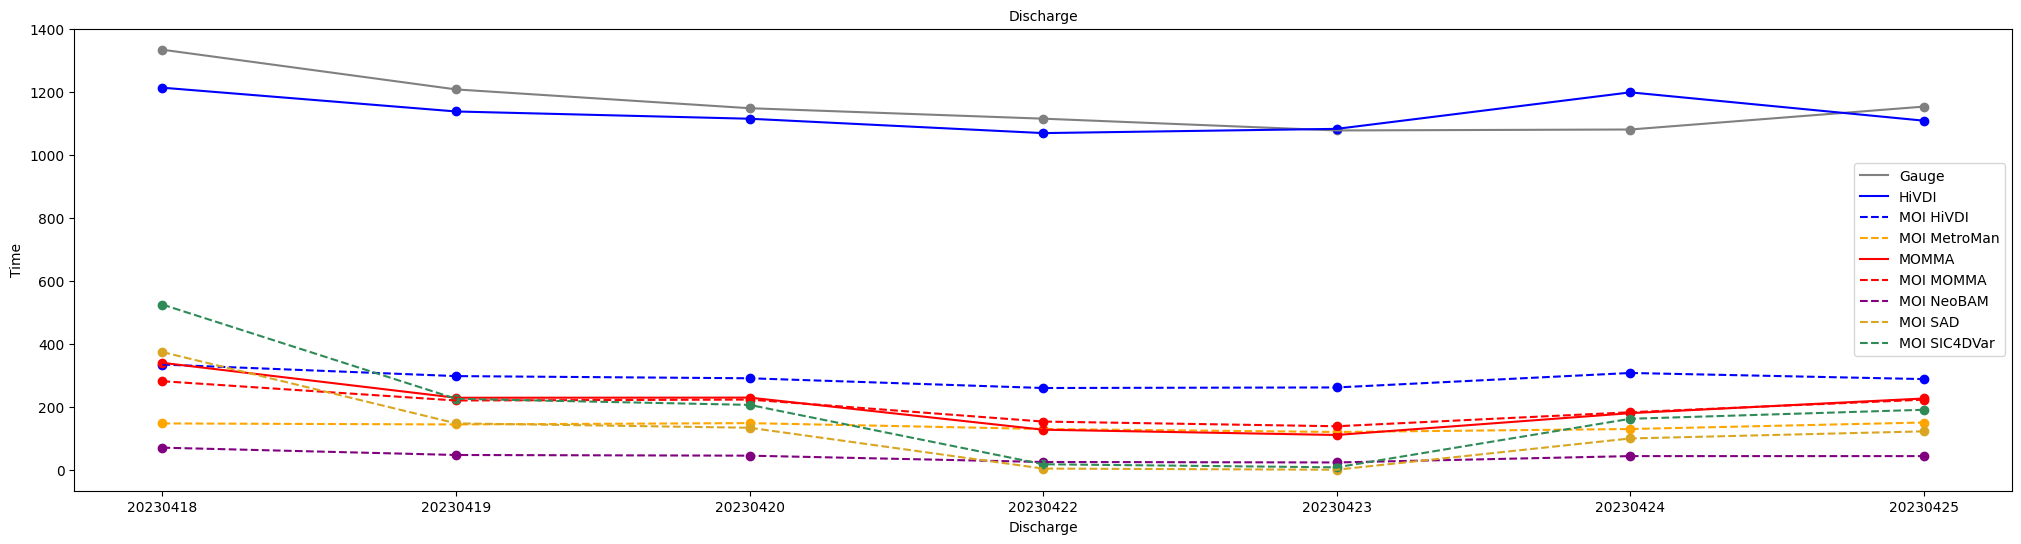

In [21]:
fig, axs = plt.subplots(figsize = (25,6))

## Build legend data
line_list = []
line_list_names = []

## Gauge
plot_discharge(axs, discharge_time, gauge_discharge, "grey", "Gauge", line_list, line_list_names)

## FLPE & MOI
plot_discharge(axs, discharge_time, hivdi_q, "blue", "HiVDI", line_list, line_list_names)
plot_discharge(axs, discharge_time, moi_hivdi, "blue", "MOI HiVDI", line_list, line_list_names)

plot_discharge(axs, discharge_time, metroman_q, "orange", "MetroMan", line_list, line_list_names)
plot_discharge(axs, discharge_time, moi_metro, "orange", "MOI MetroMan", line_list, line_list_names)

plot_discharge(axs, discharge_time, momma_q, "red", "MOMMA", line_list, line_list_names)
plot_discharge(axs, discharge_time, moi_momma, "red", "MOI MOMMA", line_list, line_list_names)

plot_discharge(axs, discharge_time, neobam_q, "purple", "NeoBAM", line_list, line_list_names)
plot_discharge(axs, discharge_time, moi_neo, "purple", "MOI NeoBAM", line_list, line_list_names)

plot_discharge(axs, discharge_time, sad_q, "goldenrod", "SAD", line_list, line_list_names)
plot_discharge(axs, discharge_time, moi_sad, "goldenrod", "MOI SAD", line_list, line_list_names)

plot_discharge(axs, discharge_time, sic4dvar_q, "seagreen", "SIC4DVar", line_list, line_list_names)
plot_discharge(axs, discharge_time, moi_sic, "seagreen", "MOI SIC4DVar", line_list, line_list_names)

# Plot details
axs.legend(line_list, line_list_names, loc='center right')
axs.set_ylabel('Time', fontsize=10)
axs.set_xlabel('Discharge', fontsize=10)
axs.set_title('Discharge', fontsize=10)

plt

--------

*Disclaimer: Reference herein to any specific commercial product, process, or service by trade name, trademark, manufacturer, or otherwise, does not constitute or imply its endorsement by the United States Government or the Jet Propulsion Laboratory, California Institute of Technology.*